In [ ]:
# Colab setup: clone repository and unzip dataset (edit REPO_URL/DATA_ZIP if needed)
# Set these variables to the repo and zip that contain your dataset
REPO_URL = 'https://github.com/Shreya-Mendi/XAI/Explainable_DL.git'  # <-- change to the repo that contains the dataset
DATA_ZIP = 'Traffic.zip'  # <-- change if different (zip inside the repo)
DATA_DIR = 'trafficnet_dataset_v1'  # expected dataset folder name after unzip or in the repo

import os
# Clone the repo if not already present
repo_name = os.path.basename(REPO_URL).replace('.git','')
if not os.path.isdir(repo_name):
    print('Cloning', REPO_URL)
    !git clone {REPO_URL}
else:
    print('Repository already cloned:', repo_name)

# If a zip file is present in the repo, unzip it into the notebook working directory
zip_path = os.path.join(repo_name, DATA_ZIP)
if os.path.exists(zip_path):
    print('Unzipping', zip_path)
    !unzip -q {zip_path} -d .
else:
    print(f'Zip not found at {zip_path}. If your dataset is a folder inside the repo, it will be moved below or you can set DATA_DIR directly.')

# If the dataset folder exists inside the cloned repo, move it to the notebook working dir
possible_dir = os.path.join(repo_name, DATA_DIR)
if os.path.isdir(possible_dir) and not os.path.isdir(DATA_DIR):
    print('Moving dataset folder from', possible_dir, 'to current dir')
    !mv {possible_dir} .

print('Colab setup complete. If needed, update DATA_DIR variable to point to your dataset folder.')

In [ ]:
!pip install torch torchvision timm opencv-python matplotlib scikit-learn pytorch-grad-cam

# Traffic classification (cleaned)

This cleaned notebook keeps the essential pipeline for training/evaluating a ResNet-based classifier and generating Grad-CAM visualizations. Unused duplicates and unrelated cells have been removed.

Instructions: install dependencies if you haven't already (run in a terminal or notebook cell):
```
pip install torch torchvision timm opencv-python matplotlib scikit-learn pytorch-grad-cam
```

Adjust `DATA_DIR` to point to your dataset and run cells in order.

In [16]:
# Imports (consolidated and minimal)
import os, random, cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import timm
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, ScoreCAM, HiResCAM
from pytorch_grad_cam.utils.image import preprocess_image, show_cam_on_image
from sklearn.metrics import confusion_matrix, classification_report

# Constants
IMG_SIZE = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
DATA_DIR = 'trafficnet_dataset_v1'  # update if needed
RESULT_DIR = 'results/cams'
os.makedirs(RESULT_DIR, exist_ok=True)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cpu


In [17]:
# Dataset transforms and loaders (kept simple)
train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1,0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
eval_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_folder = os.path.join(DATA_DIR, 'train')
test_folder = os.path.join(DATA_DIR, 'test')

# Defensive: check folders
if not os.path.isdir(train_folder) or not os.path.isdir(test_folder):
    raise FileNotFoundError(f'Expected train/test folders under {DATA_DIR}. Found: {os.listdir(DATA_DIR) if os.path.isdir(DATA_DIR) else os.listdir(".")}')

train_ds = datasets.ImageFolder(train_folder, transform=train_tf)
test_ds  = datasets.ImageFolder(test_folder, transform=eval_tf)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print('Classes:', train_ds.classes)
print('Train / Test sizes:', len(train_ds), len(test_ds))

Classes: ['accident', 'dense_traffic', 'fire', 'sparse_traffic']
Train / Test sizes: 3600 800


In [18]:
# Model creation (ResNet50 head) and move to device
num_classes = len(train_ds.classes)
model = timm.create_model('resnet50', pretrained=True, num_classes=num_classes)
model = model.to(DEVICE)

# Quick utility to print number of parameters
def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)
print('Trainable params:', count_params(model))

Trainable params: 23516228


In [ ]:
# Optional training block (set do_train=False to skip)
do_train = True
if do_train:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    epochs = 3
    for epoch in range(epochs):
        model.train()
        total, correct = 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            preds = out.argmax(dim=1)
            total += yb.size(0); correct += (preds==yb).sum().item()
        print(f'Epoch {epoch+1}/{epochs} — train_acc: {correct/total:.3f}')
    # Save checkpoint
    ckpt = 'models/resnet50_traffic.pth'
    os.makedirs(os.path.dirname(ckpt), exist_ok=True)
    torch.save(model.state_dict(), ckpt)
    print('Saved model to', ckpt)
else:
    print('Skipping training; using model as-is (pretrained head).')

Skipping training; using model as-is (pretrained head).


In [20]:
# Evaluation on test set (CPU-friendly aggregation)
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        out = model(xb)
        preds = out.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())

print(classification_report(all_labels, all_preds, target_names=test_ds.classes))
cm = confusion_matrix(all_labels, all_preds)
print('Confusion matrix:', cm)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


                precision    recall  f1-score   support

      accident       0.03      0.01      0.01       200
 dense_traffic       0.66      0.12      0.20       200
          fire       0.27      0.94      0.42       200
sparse_traffic       0.23      0.04      0.06       200

      accuracy                           0.27       800
     macro avg       0.29      0.27      0.17       800
  weighted avg       0.29      0.27      0.17       800

Confusion matrix: [[  1   1 195   3]
 [  6  23 154  17]
 [  3   5 188   4]
 [ 27   6 160   7]]


In [21]:
# Image helpers for CAMs
def load_rgb_image_resized(path, size=IMG_SIZE):
    img_bgr = cv2.imread(path)
    if img_bgr is None:
        raise FileNotFoundError(path)
    img_rgb = img_bgr[:, :, ::-1].astype(np.float32) / 255.0
    img_rgb = cv2.resize(img_rgb, (size, size))
    return img_rgb

def prep_tensor(img_rgb):
    # returns a batched tensor on DEVICE
    t = preprocess_image(img_rgb, mean=mean, std=std)
    return t.to(DEVICE)

# Sample selection: one image per class from test set
samples = []
for cls in test_ds.classes:
    cls_dir = os.path.join(test_folder, cls)
    files = [os.path.join(cls_dir, f) for f in os.listdir(cls_dir) if f.lower().endswith(('.jpg','.png','.jpeg'))]
    if files:
        samples.append(random.choice(files))

# If not enough samples, fill randomly from test_files
test_files = [os.path.join(root, f) for root, _, files in os.walk(test_folder) for f in files if f.lower().endswith(('.jpg','.png','.jpeg'))]
while len(samples) < min(5, len(test_files)):
    samples.append(random.choice(test_files))

print('Selected samples:', samples)

Selected samples: ['trafficnet_dataset_v1/test/accident/images_009.jpg', 'trafficnet_dataset_v1/test/dense_traffic/images_041 (2).jpg', 'trafficnet_dataset_v1/test/fire/images_011.jpg', 'trafficnet_dataset_v1/test/sparse_traffic/images_099 (2).jpg', 'trafficnet_dataset_v1/test/accident/images_096 (2).jpg']


In [22]:
# Choose target layer: ResNet-style fallback or last Conv2d
if hasattr(model, 'layer4'):
    target_layer = model.layer4[-1]
else:
    last_conv = None
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            last_conv = m
    if last_conv is None:
        raise RuntimeError('Could not find a Conv2d layer automatically; please pass the target layer manually.')
    target_layer = last_conv

print('Using target_layer:', target_layer)

Using target_layer: Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop_block): Identity()
  (act2): ReLU(inplace=True)
  (aa): Identity()
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act3): ReLU(inplace=True)
)


In [23]:
# Run CAMs and save visualizations (robust to single-method failures)
def run_cams_and_save(img_path, model, target_layer, methods=['gradcam','gradcam++','scorecam','hirescam'], save_dir=RESULT_DIR):
    img_rgb = load_rgb_image_resized(img_path)
    input_tensor = prep_tensor(img_rgb)

    cams = {}
    for m in methods:
        try:
            if m == 'gradcam':
                cam_obj = GradCAM(model=model, target_layers=[target_layer])
            elif m == 'gradcam++':
                cam_obj = GradCAMPlusPlus(model=model, target_layers=[target_layer])
            elif m == 'scorecam':
                cam_obj = ScoreCAM(model=model, target_layers=[target_layer])
            elif m == 'hirescam':
                cam_obj = HiResCAM(model=model, target_layers=[target_layer])
            else:
                raise ValueError('Unknown cam: ' + str(m))

            grayscale = cam_obj(input_tensor=input_tensor, targets=None)[0]
            cam_img = show_cam_on_image(img_rgb, grayscale, use_rgb=True)
            cams[m] = cam_img
        except Exception as err:
            print(f'{m} error on {os.path.basename(img_path)}: {err}')
        finally:
            try: del cam_obj
            except Exception: pass
            if DEVICE.type == 'cuda': torch.cuda.empty_cache()

    # prediction info
    with torch.no_grad():
        out = model(prep_tensor(img_rgb))
        probs = torch.softmax(out, dim=1).cpu().numpy()[0]
        pred_idx = int(probs.argmax())
        pred_conf = float(probs.max())
        try: pred_label = test_ds.classes[pred_idx]
        except Exception: pred_label = f'idx={pred_idx}'

    # plot results
    n = 1 + len(cams)
    plt.figure(figsize=(4*n, 4))
    plt.subplot(1, n, 1)
    plt.imshow(img_rgb)
    plt.title(f'Original\nPred: {pred_label} ({pred_conf:.2f})')
    plt.axis('off')
    i = 2
    for name, vis in cams.items():
        plt.subplot(1, n, i)
        plt.imshow(vis)
        plt.title(name)
        plt.axis('off')
        i += 1
    plt.show()

    # save images
    base = os.path.splitext(os.path.basename(img_path))[0]
    for name, vis in cams.items():
        outpath = os.path.join(save_dir, f'{base}_{name}.png')
        vis_u8 = (vis).astype(np.uint8)
        cv2.imwrite(outpath, cv2.cvtColor(vis_u8, cv2.COLOR_RGB2BGR))
    print('Saved cams for', os.path.basename(img_path))
    return pred_label, pred_conf

100%|██████████| 128/128 [03:16<00:00,  1.53s/it]



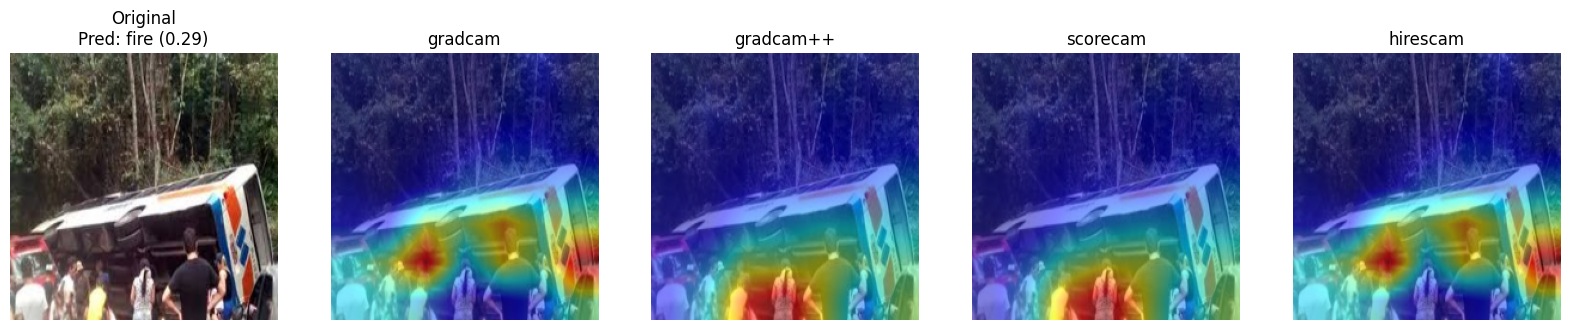

Saved cams for images_009.jpg


  1%|          | 1/128 [00:03<06:27,  3.05s/it]



KeyboardInterrupt: 

In [24]:
# Run CAMs on selected samples
for s in samples:
    try:
        run_cams_and_save(s, model, target_layer)
    except Exception as e:
        print('Error on', s, ':', e)